<div style="text-align: center;">  
    
# **Fundamentals of Data Science Final Project - Winter Semester 2023**
    
</div><br>

<div style="float: centre;">
    <table>
        <tr>
            <th style="text-align: left;">Student</th>
            <th>Matricola</th>
            <th style="text-align: left;">E-Mail</th>
        </tr>
        <tr>
            <td style="text-align: left;">Ortal Hadad</td>
            <td>2105231</td>
            <td style="text-align: left;">ortal2824@gmail.com</td>
        </tr>
        <tr>
            <td style="text-align: left;">Damian Zeller</td>
            <td>2118831</td>
            <td style="text-align: left;">damianzeller@gmx.ch</td>
        </tr>
        <tr>
            <td style="text-align: left;">André Leibrant</td>
            <td>2085698</td>
            <td style="text-align: left;">leibrant.2085698@studenti.uniroma1.it</td>
        </tr>
    </table>
</div>

---

#### Import Libraries and Modules

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib import cm
from sklearn.feature_selection import chi2, SelectKBest, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

<div style="text-align: center;">
    
# Kobe Bryant Shot Selection: <br>A Comprehensive Analysis of In-Game Shooting Behavior
<div>

## Abstract

This report explores the application of machine learning in sports analytics using the *Kobe Bryant Shot Selection* dataset. The focus is on predicting basketball shot success, employing Logistic Regression with Recursive Feature Elimination (RFE) and Backward Elimination, and K-Nearest Neighbors (KNN) with Univariate Feature Selection. The study emphasizes the impact of One Hot Encoding on model performance, as well. The report highlights the importance of preprocessing, feature engineering, and selection in machine learning, offering insights applicable to sports analytics and predictive modeling in diverse domains.

## 1. Introduction

In this assignment, we will dig into the fascinating world of basketball, specifically focusing on the analysis of a unique dataset - the *Kobe Bryant Shot Selection*. This [dataset](https://www.kaggle.com/competitions/kobe-bryant-shot-selection/overview), released by Kaggle shortly after Kobe Bryant's retirement, contains 20 years' worth of Kobe's shots, capturing various aspects of Kobe's shots during his career.

We are aiming to gain insight into one of the greatest basketball players' decision, taking on the court. Our primary objective is to train a model that can accurately predict whether a shot will be successful or not. This involves not only understanding the complex nature of basketball shots but also leveraging the power of machine learning techniques to make accurate predictions. We are going to use two classificators: Logistic Regression and K-Nearest Neighbors.

In addition, to predicting shot success, we will also aim to identify the key features that influence the outcome of a shot. This will involve a thorough exploration of the dataset, including data cleaning, feature engineering, and feature selection. We will use techniques such as Recursive Feature Elimination and Backward Elimination to try to select the most relevant features.  

Throughout this assignment, we will be using Python's powerful data science libraries like `Pandas`, `Jupyter Notebook`, and `scikit-learn` for data manipulation and analysis, and `matplotlib` for data visualization.

Our approach will be iterative, starting from data exploration and cleaning, moving on to feature engineering and selection, model building, and finally, model evaluation. We will use cross-validation techniques to ensure that our models generalize well to unseen data and provide the accuracy and log loss score to determine the best performing model. At last we are going to submit our final results to the Kaggle competition to see how we are performing in comparison to other models.

In conclusion, this assignment will provide a comprehensive understanding of how machine learning can be applied to real-world problems, particularly in the context of sports analytics. By understanding the factors that contribute to a successful shot, players can improve their performance, coaches can devise effective strategies, and fans can gain a deeper understanding of the game. By the end of this assignment, we will have developed a machine learning model that can predict the success of a Kobe Bryant shot, and we will have identified the key features that influence this outcome.

## 2. Related Work

Our study was greatly influenced by the work of other teams participating in the Kaggle challenge on Kobe Bryant's shot selection. Our analysis was guided by the insights and methodologies they employed, which included the use of various machine learning algorithms and data visualization techniques. We found these solutions insightful and incorporated some of their methodologies into our own analysis. However, we also aimed to bring a unique perspective to the problem, focusing on specific aspects of the data that we believed could provide valuable insights.  

We also read an article on Towards Data Science, which built a simple classification model to predict if a shot was made or missed. The article discussed the intuitions and practices one can leverage from data exploration to model tuning and finally evaluation. The author used a decision tree for the model which was used to discuss the process of building a simple model. The article also covered data cleaning, understanding the dataset, and data visualization.  

Also we consider a studie from GitHub which had valuable insights into how to approach the analysis of the dataset. It highlights the importance of data cleaning and feature engineering. It also demonstrates the potential of using other machine learning algorithms like Random Forest Classifier, Gaussian Naive Bayes classifier and Gradient Boosting Classifier.

#### Links:
1. https://www.kaggle.com/competitions/kobe-bryant-shot-selection/code
2. https://towardsdatascience.com/nba-data-science-93e0314bb45e
3. https://github.com/mageirakos/kobe-bryant-shot-selection/blob/master/main.ipynb

## 3. Proposed Methods Explained

The first model we are going to use for our analysis is Logistic Regression due to several reasons:

- **Binary Classification**: Clearly the problem at hand is a binary classification problem, where we need to predict whether a shot is made or not. Logistic Regression is a popular choice for binary classification problems as we saw in class.
 
- **Efficiency**: Logistic Regression is computationally efficient and can handle a large number of features without significant loss in performance. This makes it a good choice for our analysis, given the potentially large number of features in the dataset.

The seconde model are going to use is the KNN Algorithm:

- **Non-Parametric**: KNN is a non-parametric algorithm, meaning it makes no assumptions about the underlying distribution of the data. This makes it a good choice for complex datasets like the one we have, where the distribution of the data may be difficult to model.  

- **Flexibility**: KNN allows us to choose the number of neighbors to consider (k), which can be tuned to balance between bias and variance. This can be particularly useful in our analysis as we can experiment with different values of k to see which one gives the best results.

As stated in the introduction for feature selection we are going to use Recursive Feature Elimination and Backward Elimination. Both methods iteratively remove features and observes the impact on the model's performance. 

## 4. Dataset

The [dataset](https://www.kaggle.com/competitions/kobe-bryant-shot-selection/overview) we are using contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Our task is to predict whether the basket went in (`shot_made_flag`).  

Kaggle removed 5000 of the `shot_made_flags` (represented as missing values in the csv file). This is part of the Kaggle competition where we need to predict the outcome of the shot take.

The dataset contain the following attributes:<br><br>

<div style="float: centre;">
    <table class="left-align">
        <tr>
            <th style="text-align: left;">Attribute</th>
            <th style="text-align: left;">Description</th>
        </tr>
        <tr>
            <td style="text-align: left;">action_type</td>
            <td style="text-align: left;">Represents the type of action that led to the shot. It could be a layup, jump shot, or any other type of shot</td>
        </tr>
        <tr>
            <td style="text-align: left;">combined_shot_type</td>
            <td style="text-align: left;">Represents a less detailed grouped action type.</td>
        </tr>
        <tr>
            <td style="text-align: left;">game_event_id</td>
            <td style="text-align: left;">Unique identifier for each event in a game, including shots, fouls, and other actions</td>
        </tr>
        <tr>
            <td style="text-align: left;">game_id</td>
            <td style="text-align: left;">Unique identifier for each game in the dataset</td>
        </tr>
        <tr>
            <td style="text-align: left;">lat</td>
            <td style="text-align: left;">Represent the "latitude" of the shot using a specific coordinates system which is the mirror of lox_x and loc_y</td>
        </tr>
        <tr>
            <td style="text-align: left;">loc_x</td>
            <td style="text-align: left;">Represent the x coordinates of the shot on the court where (0,0) in the location of the basket</td>
        </tr>
        <tr>
            <td style="text-align: left;">loc_y</td>
            <td style="text-align: left;">Represent the y coordinates of the shot on the court where (0,0) in the location of the basket</td>
        </tr>
        <tr>
            <td style="text-align: left;">lon</td>
            <td style="text-align: left;">Represent the "longitude" of the shot using a specific coordinates system which is the mirror of lox_x and loc_y</td>
        </tr>
        <tr>
            <td style="text-align: left;">minutes_remaining</td>
            <td style="text-align: left;">Represents the number of minutes remaining in the period when the shot was taken</td>
        </tr>
        <tr>
            <td style="text-align: left;">period</td>
            <td style="text-align: left;">Represents the period in the game when the shot was taken (1st quarter, 2nd quarter, etc.)</td>
        </tr>
        <tr>
            <td style="text-align: left;">playoffs</td>
            <td style="text-align: left;">Indicates whether the game was a playoff game (1) or not (0)</td>
        </tr>
        <tr>
            <td style="text-align: left;">season</td>
            <td style="text-align: left;">Represents the season in which the game was played</td>
        </tr>
        <tr>
            <td style="text-align: left;">seconds_remaining</td>
            <td style="text-align: left;">Represents the number of seconds remaining in the period when the shot was taken</td>
        </tr>
        <tr>
            <td style="text-align: left;">shot_distance</td>
            <td style="text-align: left;">Represents the distance from the basket when the shot was taken in foot</td>
        </tr>
        <tr>
            <td style="text-align: left;">shot_made_flag</td>
            <td style="text-align: left;">Indicates whether the shot was made (1) or not (0). This is the target variable for the prediction task</td>
        </tr>
        <tr>
            <td style="text-align: left;">shot_type</td>
            <td style="text-align: left;">Represents if the shot made was a 2PT or 3PT shot</td>
        </tr>
        <tr>
            <td style="text-align: left;">shot_zone_area</td>
            <td style="text-align: left;">Represents the area of the court from which the shot was taken</td>
        </tr>
        <tr>
            <td style="text-align: left;">shot_zone_basic</td>
            <td style="text-align: left;">Represents the basic area of the court from which the shot was taken</td>
        </tr>
        <tr>
            <td style="text-align: left;">shot_zone_range</td>
            <td style="text-align: left;">Represents the range of the shot in feet</td>
        </tr>
        <tr>
            <td style="text-align: left;">team_id</td>
            <td style="text-align: left;">Unique identifier for each team in the dataset</td>
        </tr>
        <tr>
            <td style="text-align: left;">team_name</td>
            <td style="text-align: left;">Represents the name of the team that took the shot</td>
        </tr>
        <tr>
            <td style="text-align: left;">game_date</td>
            <td style="text-align: left;">Represents the date of the game</td>
        </tr>
        <tr>
            <td style="text-align: left;">matchup</td>
            <td style="text-align: left;">Represents the matchup of the teams in the game</td>
        </tr>
        <tr>
            <td style="text-align: left;">opponent</td>
            <td style="text-align: left;">Represents the opponent team</td>
        </tr>
        <tr>
            <td style="text-align: left;">shot_id</td>
            <td style="text-align: left;">Unique identifier for each shot in the dataset</td>
        </tr>
    </table>
</div>

In the following we are going to load the Kaggle dataset into a Pandas DataFrame and obtain a summary by printing the first and last five entries and by using the `info()` and `describe()` method. 

In [3]:
# File path of dataset
file_path = "/Users/damianzeller/Desktop/HS23/FDS/Final_project/data.csv"

# Load data into a Pandas DataFrame
df = pd.read_csv(file_path, delimiter=",", encoding="utf-8")

#### Print the first and last five entries:

In [4]:
df

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,Jump Shot,Jump Shot,397,49900088,33.9963,1,48,-118.2688,6,4,1,1999-00,5,4,0.0,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30693
30693,Tip Shot,Tip Shot,398,49900088,34.0443,0,0,-118.2698,6,4,1,1999-00,5,0,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30694
30694,Running Jump Shot,Jump Shot,426,49900088,33.8783,-134,166,-118.4038,3,4,1,1999-00,28,21,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30695
30695,Jump Shot,Jump Shot,448,49900088,33.7773,31,267,-118.2388,2,4,1,1999-00,10,26,0.0,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30696


#### Print the data types of each column, the number of non-null values, and the memory usage:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

#### Descriptive statistics for the numerical columns: Count, Mean, Standard Deviation, Min, 25th Percentile, Median, 75th Percentile, and Max:

In [6]:
df.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


---

Based on the summaries above we excluded in the first step for us obvious columns we won't need for our analysis and don't add any information for the overall context:
- `game_event_id` → id
- `game_id` → id
- `shot_distance` → grouped information is inside `shot_zone_range`
- `team_id` → id
- `team_name` → always *Los Angeles Lakers*
- `game_date` → grouped information is inside `season`

---

In [7]:
# List of columns to remove
columns_to_remove = ["game_event_id",
                     "game_id",
                     "shot_distance",
                     "team_id",
                     "team_name",
                     "game_date"]

# Remove the specified columns
df = df.drop(columns=columns_to_remove, axis=1)

---

After this we looked into a few variable pairs that seemed similiar to us to understand if we need all of them or can remove more variables.

---

#### `action_type` vs. `combined_shot_type`

In [8]:
df["action_type"].value_counts()

Jump Shot                             18880
Layup Shot                             2567
Driving Layup Shot                     1978
Turnaround Jump Shot                   1057
Fadeaway Jump Shot                     1048
Running Jump Shot                       926
Pullup Jump shot                        476
Turnaround Fadeaway shot                439
Slam Dunk Shot                          411
Reverse Layup Shot                      395
Jump Bank Shot                          333
Driving Dunk Shot                       310
Dunk Shot                               262
Tip Shot                                182
Alley Oop Dunk Shot                     122
Step Back Jump shot                     118
Floating Jump shot                      114
Driving Reverse Layup Shot               97
Hook Shot                                84
Driving Finger Roll Shot                 82
Alley Oop Layup shot                     80
Reverse Dunk Shot                        75
Running Layup Shot              

In [9]:
df["combined_shot_type"].value_counts()

Jump Shot    23485
Layup         5448
Dunk          1286
Tip Shot       184
Hook Shot      153
Bank Shot      141
Name: combined_shot_type, dtype: int64

---

**Note**: We are going to use only the `action_type` variable as it is has more specific information than `combined_shot_type`.

---

#### `lat` and `lon` vs. `loc_x` and `loc_y`

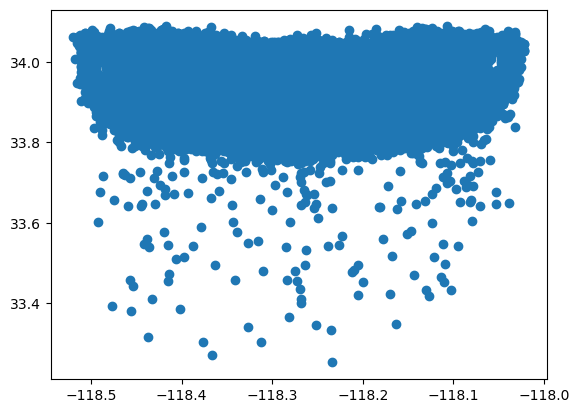

In [10]:
plt.scatter(x=df["lon"], y=df["lat"]);

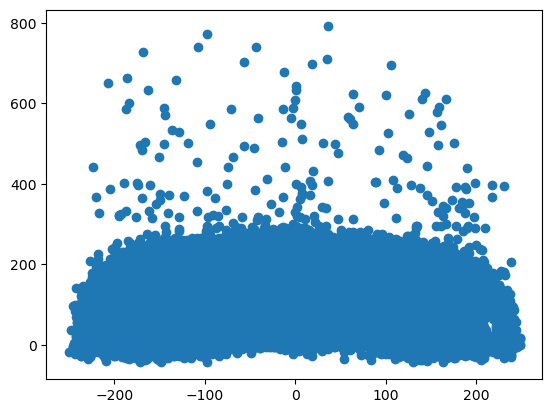

In [11]:
plt.scatter(x=df["loc_x"],y=df["loc_y"]);

---

**Note**: We are going to use only the `loc_x` and `loc_y` variables for the taken shot position because as we can see above `lat` and `lon` provide the same information but in a different coordinate system.
 
---

#### `shot_zone_area` vs. `shot_zone_basic` vs. `shot_zone_range`

In [12]:
df["shot_zone_area"].value_counts()

Center(C)                13455
Right Side Center(RC)     4776
Right Side(R)             4588
Left Side Center(LC)      4044
Left Side(L)              3751
Back Court(BC)              83
Name: shot_zone_area, dtype: int64

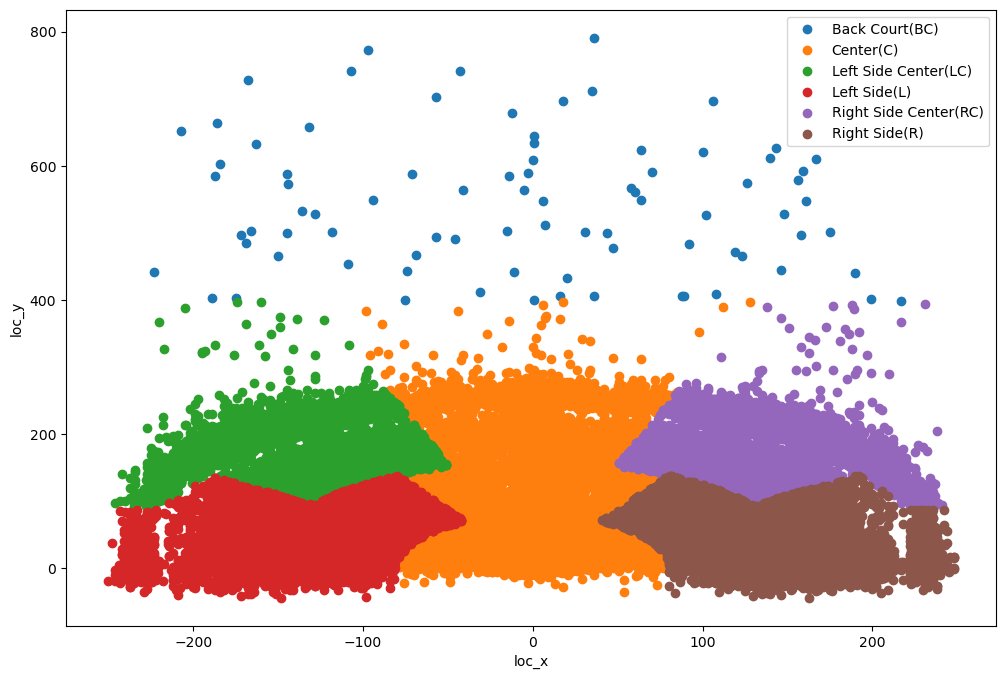

In [13]:
# Group by shot zone area
areas = df.groupby("shot_zone_area")

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each group with a different color
for name, area in areas:
    ax.scatter(area["loc_x"], area["loc_y"], label=name)

# Add labels and legend
ax.set_xlabel("loc_x")
ax.set_ylabel("loc_y")
ax.legend()

# Show plot
plt.show()

In [14]:
df["shot_zone_basic"].value_counts()

Mid-Range                12625
Restricted Area           7136
Above the Break 3         5620
In The Paint (Non-RA)     4578
Right Corner 3             387
Left Corner 3              280
Backcourt                   71
Name: shot_zone_basic, dtype: int64

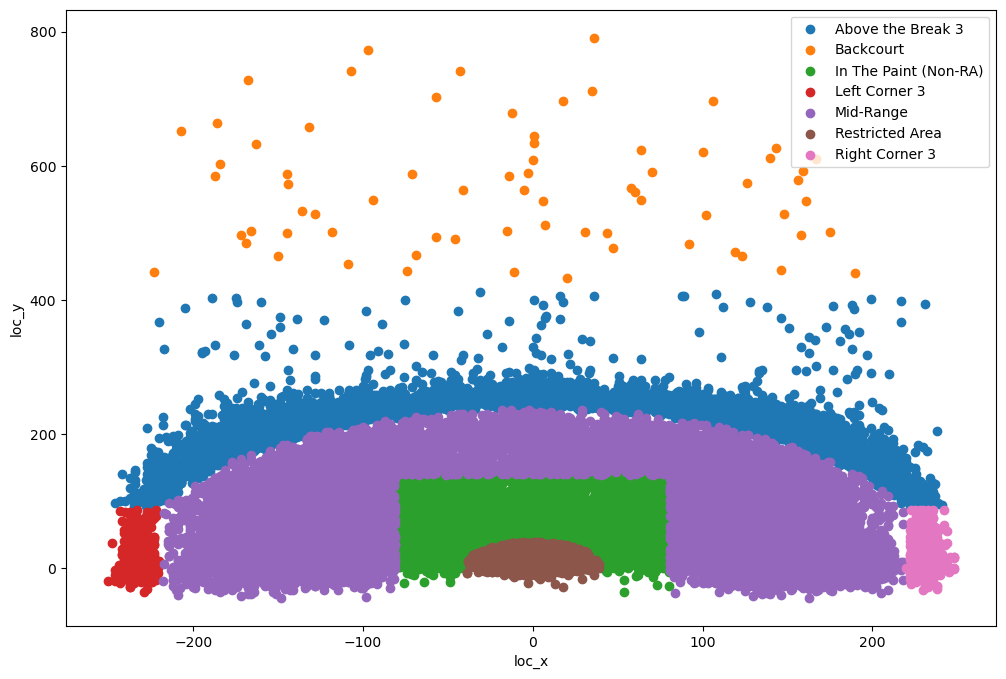

In [15]:
# Group by shot zone basic
areas = df.groupby("shot_zone_basic")

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each group with a different color
for name, area in areas:
    ax.scatter(area["loc_x"], area["loc_y"], label=name)

# Add labels and legend
ax.set_xlabel("loc_x")
ax.set_ylabel("loc_y")
ax.legend()

# Show plot
plt.show()

In [16]:
df["shot_zone_range"].value_counts()

Less Than 8 ft.    9398
16-24 ft.          8315
8-16 ft.           6626
24+ ft.            6275
Back Court Shot      83
Name: shot_zone_range, dtype: int64

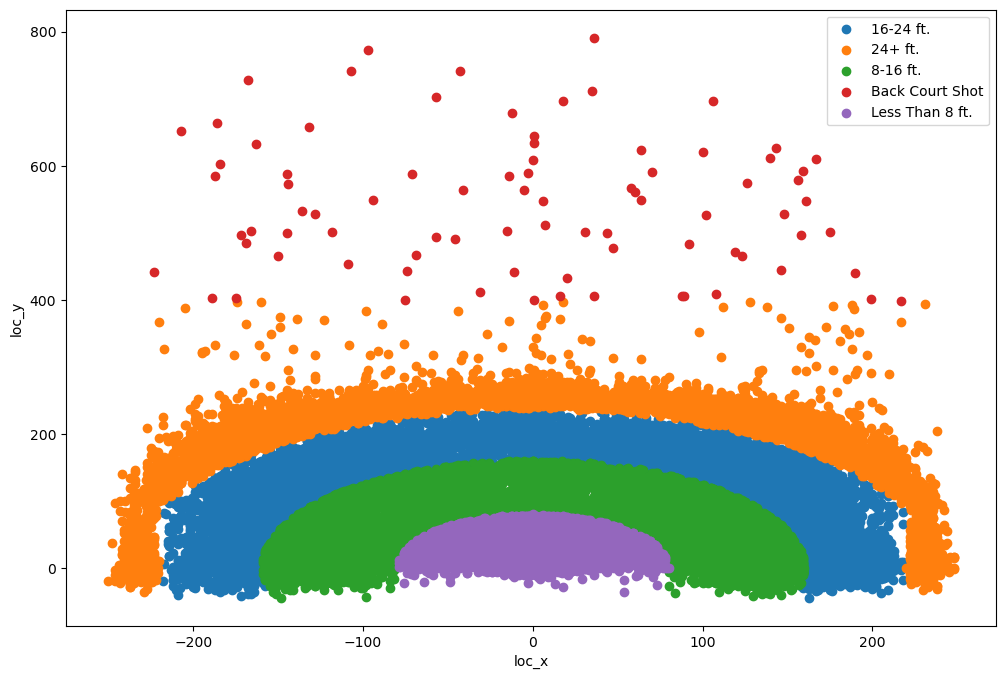

In [17]:
# Group by shot zone range
areas = df.groupby("shot_zone_range")

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each group with a different color
for name, area in areas:
    ax.scatter(area["loc_x"], area["loc_y"], label=name)

# Add labels and legend
ax.set_xlabel("loc_x")
ax.set_ylabel("loc_y")
ax.legend()

# Show plot
plt.show()

---

**Note:** Based on what we see in the plots of `shot_zone_area`, `shot_zone_basic`, and `shot_zone_range` we define a new variable `new_shot_zone_area` that combines the information of all three variables representing the official shot zone areas.

---

In [18]:
# Define new column with official shot zone areas
df["new_shot_zone_area"] = "Other"

df.loc[df["shot_zone_basic"] == "Backcourt", "new_shot_zone_area"] = "Backcourt"
df.loc[df["shot_zone_basic"] == "Above the Break 3", "new_shot_zone_area"] = "Above the Break 3"
df.loc[df["shot_zone_basic"] == "Left Corner 3", "new_shot_zone_area"] = "Left Corner 3"
df.loc[df["shot_zone_basic"] == "Right Corner 3", "new_shot_zone_area"] = "Right Corner 3"
df.loc[(df["shot_zone_area"] == "Left Side(L)") &
        (df["shot_zone_range"] == "16-24 ft."), "new_shot_zone_area"] = "Left Long Baseline"
df.loc[(df["shot_zone_area"] == "Left Side Center(LC)") &
        (df["shot_zone_range"] == "16-24 ft."), "new_shot_zone_area"] = "Left Long Wing"
df.loc[(df["shot_zone_area"] == "Center(C)") &
        (df["shot_zone_range"] == "16-24 ft."), "new_shot_zone_area"] = "Long Straight"
df.loc[(df["shot_zone_area"] == "Right Side Center(RC)") &
        (df["shot_zone_range"] == "16-24 ft."), "new_shot_zone_area"] = "Right Long Wing"
df.loc[(df["shot_zone_area"] == "Right Side(R)") &
        (df["shot_zone_range"] == "16-24 ft."), "new_shot_zone_area"] = "Right Long Baseline"
df.loc[(df["shot_zone_area"] == "Left Side(L)") &
        (df["shot_zone_range"] == "8-16 ft."), "new_shot_zone_area"] = "Left Mid Baseline to Elbow"
df.loc[(df["shot_zone_area"] == "Center(C)") &
        (df["shot_zone_range"] == "8-16 ft."), "new_shot_zone_area"] = "Mid Straight"
df.loc[(df["shot_zone_area"] == "Right Side(R)") &
        (df["shot_zone_range"] == "8-16 ft."), "new_shot_zone_area"] = "Right Mid Baseline to Elbow"
df.loc[df["shot_zone_range"] == "Less Than 8 ft.", "new_shot_zone_area"] = "Around Rim"

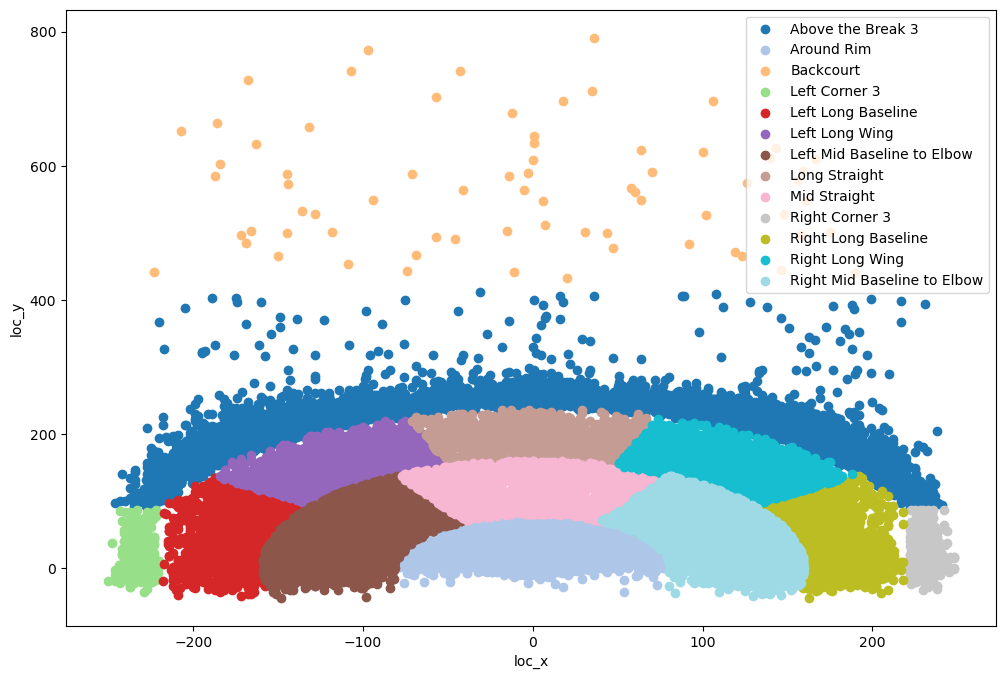

In [19]:
# Group by new shot zone range
areas = df.groupby("new_shot_zone_area")

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Get a colormap and create an iterator
cmap = matplotlib.colormaps["tab20"]
colors = iter(cmap(np.linspace(0, 1, len(areas))))

# Plot each group with a different color
for name, area in areas:
    ax.scatter(area["loc_x"], area["loc_y"], label=name, color=next(colors))

# Add labels and legend
ax.set_xlabel("loc_x")
ax.set_ylabel("loc_y")
ax.legend()

# Show plot
plt.show()

#### `minutes_remaining` vs. `seconds_remaining`

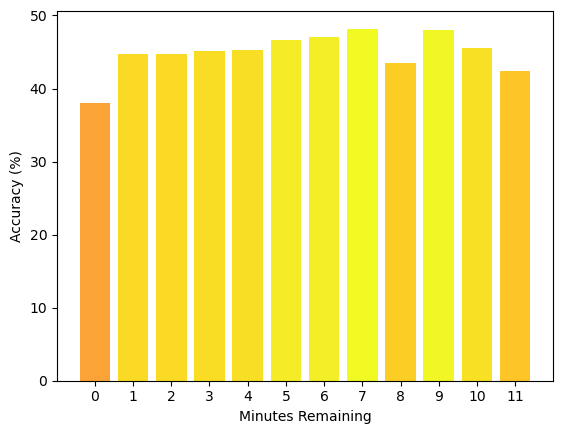

In [20]:
# Calculate accuracy for every minute remaining
accuracy = df.groupby("minutes_remaining")["shot_made_flag"].mean()*100

# Create a colormap
cmap = matplotlib.colormaps["plasma"]

# Plot the accuracy heatmap
plt.bar(accuracy.index.astype(str), accuracy, color=cmap(accuracy / accuracy.max()))
plt.xlabel("Minutes Remaining")
plt.ylabel("Accuracy (%)")
plt.show()

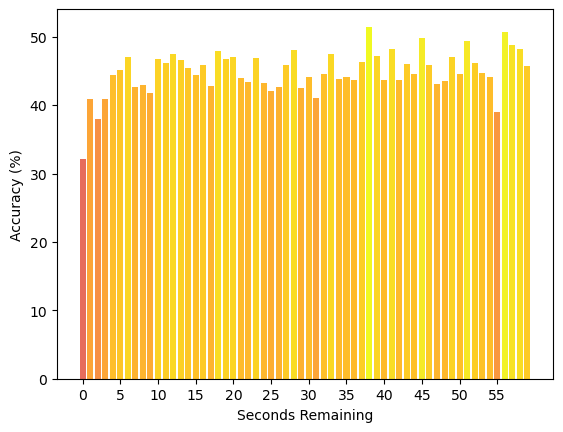

In [21]:
# Calculate accuracy for every second remaining
accuracy = df.groupby("seconds_remaining")["shot_made_flag"].mean()*100

# Create a colormap
cmap = matplotlib.colormaps["plasma"]

# Plot the accuracy heatmap
plt.bar(accuracy.index.astype(str), accuracy, color=cmap(accuracy / accuracy.max()))
plt.xlabel("Seconds Remaining")
plt.ylabel("Accuracy (%)")
plt.xticks(range(0, len(accuracy.index), 5), accuracy.index[::5])
plt.show()

---

**Note:** We are not sure if we should only consider `seconds_remaining` or also `minutes_remaining`. For now we are going to keep both and evaluate later in a deep dive.

---

#### `period`

In [22]:
df["period"].value_counts()

3    8296
1    8048
4    7260
2    6718
5     330
6      38
7       7
Name: period, dtype: int64

---

**Note:** We are going to create a new column `overtime` which groups the periods 1, 2, 3, and 4 to `0` and the others (5, 6, and 7) into `1` indicating if the shot was made during the first four regular quarters or in overtime.

---

In [23]:
# Define new column overtime
df["overtime"] = 0

df.loc[df["period"].isin([1, 2, 3, 4]), "overtime"] = 0
df.loc[~df["period"].isin([1, 2, 3, 4]), "overtime"] = 1

#### `matchup`

**Note**: We are going to create a new variable `home` based on the column `matchup` which is `1` if they played at home in Los Angeles and `0` if they played away.

---

In [24]:
# Define new column home
df["home"] = np.where(df["matchup"].str.contains("@"), 1, 0)
df["home"] = np.where(df["matchup"].str.contains("vs."), 0, df["home"])

Based on the first deeper analysis between a few variables we are going to remove the following variables:
- `combined_shot_type`
- `lat`
- `lon`
- `shot_zone_area`
- `shot_zone_basic`
- `shot_zone_range`
- `matchup`

In [25]:
# List of columns to remove
columns_to_remove = ["combined_shot_type",
                     "lat",
                     "lon",
                     "shot_zone_area",
                     "shot_zone_basic",
                     "shot_zone_range",
                     "matchup"]

# Remove the specified columns
df = df.drop(columns=columns_to_remove, axis=1)

#### This is the dataset we are left with:

In [26]:
df

,action_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_made_flag,shot_type,opponent,shot_id,new_shot_zone_area,overtime,home
0,Jump Shot,167,72,10,1,0,2000-01,27,NaN,2PT Field Goal,POR,1,Right Long Baseline,0,1
1,Jump Shot,-157,0,10,1,0,2000-01,22,0.0,2PT Field Goal,POR,2,Left Mid Baseline to Elbow,0,1
2,Jump Shot,-101,135,7,1,0,2000-01,45,1.0,2PT Field Goal,POR,3,Left Long Wing,0,1
3,Jump Shot,138,175,6,1,0,2000-01,52,0.0,2PT Field Goal,POR,4,Right Long Wing,0,1
4,Driving Dunk Shot,0,0,6,2,0,2000-01,19,1.0,2PT Field Goal,POR,5,Around Rim,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,Jump Shot,1,48,6,4,1,1999-00,5,0.0,2PT Field Goal,IND,30693,Around Rim,0,0
30693,Tip Shot,0,0,6,4,1,1999-00,5,NaN,2PT Field Goal,IND,30694,Around Rim,0,0
30694,Running Jump Shot,-134,166,3,4,1,1999-00,28,1.0,2PT Field Goal,IND,30695,Left Long Wing,0,0
30695,Jump Shot,31,267,2,4,1,1999-00,10,0.0,3PT Field Goal,IND,30696,Above the Break 3,0,0


## 5. Experimental Results

Before doing any analysis we are going to encode all categorical variables.

In [27]:
# Create label encoder
le = LabelEncoder()

# Save a copy of the original DataFrame
df_copy = df.copy()

# Encode all categorical variables
df["encoded_action_type"] = le.fit_transform(df["action_type"])
df["encoded_season"] = le.fit_transform(df["season"])
df["encoded_shot_type"] = le.fit_transform(df["shot_type"])
df["encoded_opponent"] = le.fit_transform(df["opponent"])
df["encoded_new_shot_zone_area"] = le.fit_transform(df["new_shot_zone_area"])

In [28]:
df

,action_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_made_flag,shot_type,opponent,shot_id,new_shot_zone_area,overtime,home,encoded_action_type,encoded_season,encoded_shot_type,encoded_opponent,encoded_new_shot_zone_area
0,Jump Shot,167,72,10,1,0,2000-01,27,NaN,2PT Field Goal,POR,1,Right Long Baseline,0,1,26,4,0,25,10
1,Jump Shot,-157,0,10,1,0,2000-01,22,0.0,2PT Field Goal,POR,2,Left Mid Baseline to Elbow,0,1,26,4,0,25,6
2,Jump Shot,-101,135,7,1,0,2000-01,45,1.0,2PT Field Goal,POR,3,Left Long Wing,0,1,26,4,0,25,5
3,Jump Shot,138,175,6,1,0,2000-01,52,0.0,2PT Field Goal,POR,4,Right Long Wing,0,1,26,4,0,25,11
4,Driving Dunk Shot,0,0,6,2,0,2000-01,19,1.0,2PT Field Goal,POR,5,Around Rim,0,1,5,4,0,25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,Jump Shot,1,48,6,4,1,1999-00,5,0.0,2PT Field Goal,IND,30693,Around Rim,0,0,26,3,0,11,1
30693,Tip Shot,0,0,6,4,1,1999-00,5,NaN,2PT Field Goal,IND,30694,Around Rim,0,0,50,3,0,11,1
30694,Running Jump Shot,-134,166,3,4,1,1999-00,28,1.0,2PT Field Goal,IND,30695,Left Long Wing,0,0,41,3,0,11,5
30695,Jump Shot,31,267,2,4,1,1999-00,10,0.0,3PT Field Goal,IND,30696,Above the Break 3,0,0,26,3,1,11,0


---

We are going to save all 5000 points with a `NaN` in `shot_made_flag` in a seperate DataFrame which we are going to predict after we have our best prediction model and submit to the Kaggle competition.

---

In [29]:
# Data we are going to train and test our models
test_df = df[df["shot_made_flag"].isin([0, 1])]

# Data we are going to predict the shot_made_flag and submit to the Kaggle competition
predict_df = df[~df["shot_made_flag"].isin([0, 1])]

Before training any model we seperate the feature variables from the variable to predict, we split the data into a training set (80%) and testing set (20%), and we scale all the features.

In [30]:
# Select all features variables
X = test_df[["minutes_remaining",
             "period",
             "playoffs",
             "seconds_remaining",
             "overtime",
             "home",
             "encoded_action_type", 
             "encoded_season",
             "encoded_shot_type",
             "encoded_opponent",
             "encoded_new_shot_zone_area"]]

# Select variable to predict
y = test_df["shot_made_flag"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale all features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

For our first model we chose to train a Logistical Regression model using all the features.

Accuracy: 0.5894941634241245
Log Loss: 0.6736324494686887

Classification Report:


,precision,recall,f1-score,support
0.0,0.614030,0.724628,0.664760,2887.000000
1.0,0.541258,0.416334,0.470647,2253.000000
accuracy,0.589494,0.589494,0.589494,0.589494
macro avg,0.577644,0.570481,0.567704,5140.000000
weighted avg,0.582132,0.589494,0.579675,5140.000000


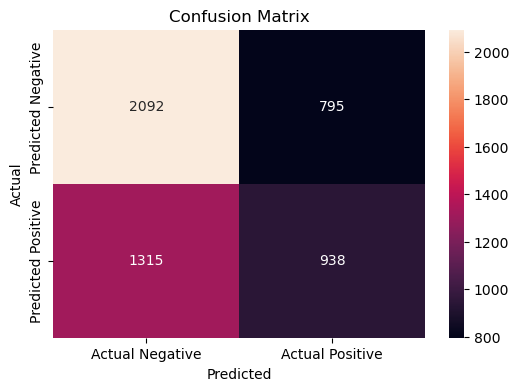

In [31]:
# Initialize and train the Logistic Regression model with all features
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model by calculating the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate log loss score
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1] 
log_loss_score = log_loss(y_test, y_pred_prob)
print(f"Log Loss: {log_loss_score}\n")

# Additional evaluation metrics
print("Classification Report:")
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
display(report_df)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert the confusion matrix to a DataFrame
cm_df = pd.DataFrame(cm,
                     index=["Predicted Negative", "Predicted Positive"],
                     columns=["Actual Negative", "Actual Positive"])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In the next step we are going to do some feature engineering by applying Recursive Feature Elimination first and then Backward Elimination.

In [32]:
# Initialize Logistic Regression model
logreg_model = LogisticRegression()

# Apply Recursive Feature Elimination for feature selection
rfe = RFE(logreg_model, n_features_to_select=1)
fit = rfe.fit(X_train_scaled, y_train)

# Print selected features based on RFE
selected_features = pd.DataFrame({"Feature": X_train.columns, "Ranking": fit.ranking_})
selected_features = selected_features.sort_values(by="Ranking")

print("Selected Features:")
print(selected_features)

Selected Features:
                       Feature  Ranking
8            encoded_shot_type        1
10  encoded_new_shot_zone_area        2
3            seconds_remaining        3
1                       period        4
6          encoded_action_type        5
5                         home        6
0            minutes_remaining        7
9             encoded_opponent        8
2                     playoffs        9
4                     overtime       10
7               encoded_season       11


In [33]:
# Create empty lists to store k and accuracy scores
k_values = []
accuracy_scores = []

# Iterate over all top k features
for k in range(1, len(selected_features)):
    
    # Select the top k features
    selected_columns = selected_features.head(k)["Feature"].tolist()

    # Extract indices corresponding to the selected features
    selected_indices = [X.columns.get_loc(feature) for feature in selected_columns]

    # Use the selected columns to train the Logistic Regression model
    X_train_selected = X_train_scaled[:, selected_indices]
    X_test_selected = X_test_scaled[:, selected_indices]

    logreg_model.fit(X_train_selected, y_train)

    # Make predictions on the test set
    y_pred = logreg_model.predict(X_test_selected)

    # Evaluate the model and append k and accuracy to the lists
    accuracy = accuracy_score(y_test, y_pred)
    k_values.append(k)
    accuracy_scores.append(accuracy)

# Create a DataFrame to display the results
result_df = pd.DataFrame({"Accuracy": accuracy_scores}, index=k_values).rename_axis("k")

result_df

,Accuracy
k,
1,0.561673
2,0.590661
3,0.597471
4,0.596693
5,0.594163
6,0.586965
7,0.586381
8,0.588911
9,0.588327


Based on the results of the Recursive Feature Elimination we get the best score for `k = 3` including only the features `encoded_shot_type`, `encoded_new_shot_zone_area`, and `seconds_remaining`. We are going to present some benchmarks of this model in the next step.

Accuracy: 0.5974708171206226
Log Loss: 0.6734416632327054 

Classification Report:


,precision,recall,f1-score,support
0.0,0.618345,0.740215,0.673814,2887.000000
1.0,0.554632,0.414558,0.474473,2253.000000
accuracy,0.597471,0.597471,0.597471,0.597471
macro avg,0.586488,0.577387,0.574143,5140.000000
weighted avg,0.590418,0.597471,0.586437,5140.000000


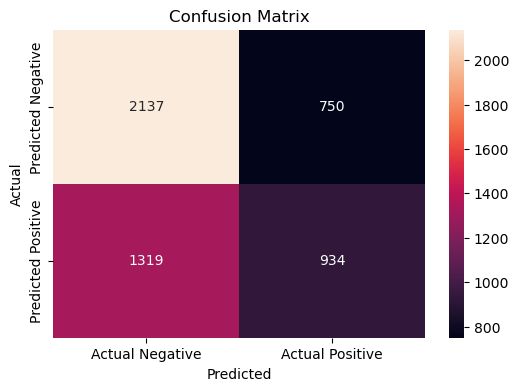

In [34]:
# Select the top k features
k = 3
selected_columns = selected_features.head(k)["Feature"].tolist()

# Extract indices corresponding to the selected features
selected_indices = [X.columns.get_loc(feature) for feature in selected_columns]

# Use the selected columns to train the Logistic Regression model
X_train_selected = X_train_scaled[:, selected_indices]
X_test_selected = X_test_scaled[:, selected_indices]

logreg_model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_test_selected)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate log loss score
y_pred_prob = logreg_model.predict_proba(X_test_selected)[:, 1] 
log_loss_score = log_loss(y_test, y_pred_prob)
print(f"Log Loss: {log_loss_score} \n")

# Print classification report
print("Classification Report:")
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
display(report_df)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert the confusion matrix to a DataFrame
cm_df = pd.DataFrame(cm,
                     index=["Predicted Negative", "Predicted Positive"],
                     columns=["Actual Negative", "Actual Positive"])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Save model
best_model = logreg_model

In the next step we are going to apply Backward Elimination.

In [35]:
# Scale the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add a constant term for the intercept
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Initialize Logistic Regression model
logreg_model = sm.Logit(y_train, X_train_scaled)

# Initialize a list with all feature names
feature_names = list(X_train.columns)

# Perform Backward Elimination
while True:
    
    # Fit the Logistic Regression model
    result = logreg_model.fit(disp=False)

    # Check p-values and eliminate the least significant feature
    if result.pvalues.max() > 0.05:
        
        # Index of least significant feature excluding the intercept
        least_significant_feature_index = np.argmax(result.pvalues)
        
        # Remove the least significant feature from the data and the feature names list
        X_train_scaled = np.delete(X_train_scaled, least_significant_feature_index, axis=1)
        X_test_scaled = np.delete(X_test_scaled, least_significant_feature_index, axis=1)
        if least_significant_feature_index < len(feature_names):
            del feature_names[least_significant_feature_index]

        # Update the Logistic Regression model with the new set of features
        logreg_model = sm.Logit(y_train, X_train_scaled)
    else:
        break

# Train the Logistic Regression model with the selected features
final_logreg_model = sm.Logit(y_train, X_train_scaled)
final_result = final_logreg_model.fit()

# Print the final summary
print(final_result.summary())

# Make predictions on the test set
y_pred = final_result.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)

# Print finally selected features
print(f"\nSelected features: {feature_names}\n")

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate log loss score
log_loss_score = log_loss(y_test, y_pred)
print(f"Log Loss: {log_loss_score} \n")

Optimization terminated successfully.
         Current function value: 0.673123
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:         shot_made_flag   No. Observations:                20557
Model:                          Logit   Df Residuals:                    20549
Method:                           MLE   Df Model:                            7
Date:                Sat, 16 Dec 2023   Pseudo R-squ.:                 0.02127
Time:                        18:17:47   Log-Likelihood:                -13837.
converged:                       True   LL-Null:                       -14138.
Covariance Type:            nonrobust   LLR p-value:                1.132e-125
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2160      0.014    -15.155      0.000      -0.244      -0.188
x1             0.0380      0.

---

**Note**: The Backward Elimination returns a model with selecting more features but it performs slightly worse than what we got with RFE.

---

Inspired by this [source](https://towardsdatascience.com/nba-data-science-93e0314bb45e) we one hot encode all the columns and redo the feature engineering with the new features.

In [36]:
# Extract variable to predict
y = df.dropna(subset=["shot_made_flag"])["shot_made_flag"]

# Seperate the data in a DataFrame with the shots we have to predict for the Kaggle competition and one hot encode
# all the columns
df_predict = df_copy[df_copy["shot_made_flag"].isna()]
df_predict = df_predict.drop(columns=["shot_made_flag", "loc_x", "loc_y", "shot_id"])
df_predict = pd.get_dummies(df_predict, columns=["period"])
df_predict = pd.get_dummies(df_predict, columns=df.select_dtypes(include=["object"]).columns).astype(int)

# Seperate the data in a DataFrame with the know shots and one hot encode all the columns
df_encoded = df_copy.dropna(subset=["shot_made_flag"])
df_encoded = df_encoded.drop(columns=["shot_made_flag", "loc_x", "loc_y", "shot_id"])
df_encoded = pd.get_dummies(df_encoded, columns=["period"])
df_encoded = pd.get_dummies(df_encoded, columns=df.select_dtypes(include=["object"]).columns).astype(int)

df_encoded

,minutes_remaining,playoffs,seconds_remaining,overtime,home,period_1,period_2,period_3,period_4,period_5,period_6,period_7,action_type_Alley Oop Dunk Shot,action_type_Alley Oop Layup shot,action_type_Cutting Layup Shot,action_type_Driving Bank shot,action_type_Driving Dunk Shot,action_type_Driving Finger Roll Layup Shot,action_type_Driving Finger Roll Shot,action_type_Driving Floating Bank Jump Shot,action_type_Driving Floating Jump Shot,action_type_Driving Hook Shot,action_type_Driving Jump shot,action_type_Driving Layup Shot,action_type_Driving Reverse Layup Shot,action_type_Driving Slam Dunk Shot,action_type_Dunk Shot,action_type_Fadeaway Bank shot,action_type_Fadeaway Jump Shot,action_type_Finger Roll Layup Shot,action_type_Finger Roll Shot,action_type_Floating Jump shot,action_type_Follow Up Dunk Shot,action_type_Hook Bank Shot,action_type_Hook Shot,action_type_Jump Bank Shot,action_type_Jump Hook Shot,action_type_Jump Shot,action_type_Layup Shot,action_type_Pullup Bank shot,action_type_Pullup Jump shot,action_type_Putback Dunk Shot,action_type_Putback Layup Shot,action_type_Putback Slam Dunk Shot,action_type_Reverse Dunk Shot,action_type_Reverse Layup Shot,action_type_Reverse Slam Dunk Shot,action_type_Running Bank shot,action_type_Running Dunk Shot,action_type_Running Finger Roll Layup Shot,action_type_Running Finger Roll Shot,action_type_Running Hook Shot,action_type_Running Jump Shot,action_type_Running Layup Shot,action_type_Running Pull-Up Jump Shot,action_type_Running Reverse Layup Shot,action_type_Running Slam Dunk Shot,action_type_Running Tip Shot,action_type_Slam Dunk Shot,action_type_Step Back Jump shot,action_type_Tip Layup Shot,action_type_Tip Shot,action_type_Turnaround Bank shot,action_type_Turnaround Fadeaway shot,action_type_Turnaround Finger Roll Shot,action_type_Turnaround Hook Shot,action_type_Turnaround Jump Shot,season_1996-97,season_1997-98,season_1998-99,season_1999-00,season_2000-01,season_2001-02,season_2002-03,season_2003-04,season_2004-05,season_2005-06,season_2006-07,season_2007-08,season_2008-09,season_2009-10,season_2010-11,season_2011-12,season_2012-13,season_2013-14,season_2014-15,season_2015-16,shot_type_2PT Field Goal,shot_type_3PT Field Goal,opponent_ATL,opponent_BKN,opponent_BOS,opponent_CHA,opponent_CHI,opponent_CLE,opponent_DAL,opponent_DEN,opponent_DET,opponent_GSW,opponent_HOU,opponent_IND,opponent_LAC,opponent_MEM,opponent_MIA,opponent_MIL,opponent_MIN,opponent_NJN,opponent_NOH,opponent_NOP,opponent_NYK,opponent_OKC,opponent_ORL,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS,new_shot_zone_area_Above the Break 3,new_shot_zone_area_Around Rim,new_shot_zone_area_Backcourt,new_shot_zone_area_Left Corner 3,new_shot_zone_area_Left Long Baseline,new_shot_zone_area_Left Long Wing,new_shot_zone_area_Left Mid Baseline to Elbow,new_shot_zone_area_Long Straight,new_shot_zone_area_Mid Straight,new_shot_zone_area_Right Corner 3,new_shot_zone_area_Right Long Baseline,new_shot_zone_area_Right Long Wing,new_shot_zone_area_Right Mid Baseline to Elbow
1,10,0,22,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,7,0,45,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,6,0,52,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,6,0,19,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,

We start again with training a Logistic Regression model with all features.

In [37]:
# Select all features variables
X = df_encoded

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale all features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Accuracy: 0.6813229571984436
Log Loss: 0.6135975700397384

Classification Report:


,precision,recall,f1-score,support
0.0,0.667741,0.861101,0.752194,2887.000000
1.0,0.717008,0.450954,0.553678,2253.000000
accuracy,0.681323,0.681323,0.681323,0.681323
macro avg,0.692374,0.656028,0.652936,5140.000000
weighted avg,0.689336,0.681323,0.665179,5140.000000


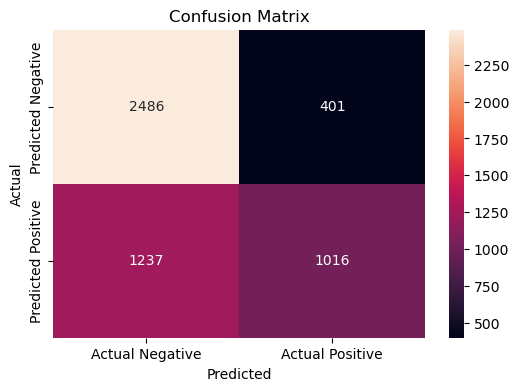

In [38]:
# Initialize and train the Logistic Regression model with all features
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model by calculating the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate log loss score
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1] 
log_loss_score = log_loss(y_test, y_pred_prob)
print(f"Log Loss: {log_loss_score}\n")

# Additional evaluation metrics
print("Classification Report:")
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
display(report_df)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert the confusion matrix to a DataFrame
cm_df = pd.DataFrame(cm,
                     index=["Predicted Negative", "Predicted Positive"],
                     columns=["Actual Negative", "Actual Positive"])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

Next we apply Recursive Feature Elimination.

In [39]:
# Initialize Logistic Regression model
logreg_model = LogisticRegression()

# Apply Recursive Feature Elimination for feature selection
rfe = RFE(logreg_model, n_features_to_select=1)
fit = rfe.fit(X_train_scaled, y_train)

# Print selected features based on RFE
selected_features = pd.DataFrame({"Feature": X_train.columns, "Ranking": fit.ranking_})
selected_features = selected_features.sort_values(by="Ranking")

print("Selected Features:")
print(selected_features)

Selected Features:
                                        Feature  Ranking
37                        action_type_Jump Shot        1
58                   action_type_Slam Dunk Shot        2
38                       action_type_Layup Shot        3
16                action_type_Driving Dunk Shot        4
46           action_type_Reverse Slam Dunk Shot        5
..                                          ...      ...
11                                     period_7      131
70                               season_1999-00      132
49   action_type_Running Finger Roll Layup Shot      133
121                                opponent_WAS      134
15                action_type_Driving Bank shot      135

[135 rows x 2 columns]


In [40]:
# Create empty lists to store k and accuracy scores
k_values = []
accuracy_scores = []

# Iterate over all top k features
for k in range(1, len(selected_features)):
    
    # Select the top k features
    selected_columns = selected_features.head(k)["Feature"].tolist()

    # Extract indices corresponding to the selected features
    selected_indices = [X.columns.get_loc(feature) for feature in selected_columns]

    # Use the selected columns to train the Logistic Regression model
    X_train_selected = X_train_scaled[:, selected_indices]
    X_test_selected = X_test_scaled[:, selected_indices]

    logreg_model.fit(X_train_selected, y_train)

    # Make predictions on the test set
    y_pred = logreg_model.predict(X_test_selected)

    # Evaluate the model and append k and accuracy to the lists
    accuracy = accuracy_score(y_test, y_pred)
    k_values.append(k)
    accuracy_scores.append(accuracy)

# Create a DataFrame to display the results
result_df = pd.DataFrame({"Accuracy": accuracy_scores}, index=k_values).rename_axis("k")

max_accuracy = result_df["Accuracy"].max()
index_of_max_accuracy = result_df["Accuracy"].idxmax()

print(f"Maximum Accuracy: {max_accuracy}")
print(f"Index of Maximum Accuracy: {index_of_max_accuracy}")

Maximum Accuracy: 0.6840466926070039
Index of Maximum Accuracy: 25


Based on the results of the Recursive Feature Elimination we get the best score for `k = 25` including only the first 25 features. We are going to present some benchmarks of this model in the next step.

Accuracy: 0.6840466926070039
Log Loss: 0.6140360089574511 

Classification Report:


,precision,recall,f1-score,support
0.0,0.671650,0.855906,0.752665,2887.000000
1.0,0.715264,0.463826,0.562736,2253.000000
accuracy,0.684047,0.684047,0.684047,0.684047
macro avg,0.693457,0.659866,0.657700,5140.000000
weighted avg,0.690767,0.684047,0.669414,5140.000000


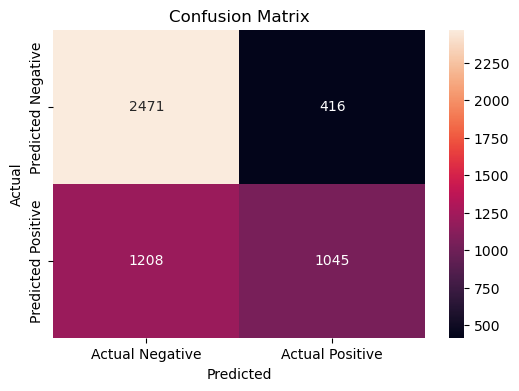

In [41]:
# Select the top k features
k = 25
selected_columns = selected_features.head(k)["Feature"].tolist()

# Extract indices corresponding to the selected features
selected_indices = [X.columns.get_loc(feature) for feature in selected_columns]

# Use the selected columns to train the Logistic Regression model
X_train_selected = X_train_scaled[:, selected_indices]
X_test_selected = X_test_scaled[:, selected_indices]

logreg_model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_test_selected)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate log loss score
y_pred_prob = logreg_model.predict_proba(X_test_selected)[:, 1] 
log_loss_score = log_loss(y_test, y_pred_prob)
print(f"Log Loss: {log_loss_score} \n")

# Print classification report
print("Classification Report:")
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
display(report_df)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert the confusion matrix to a DataFrame
cm_df = pd.DataFrame(cm,
                     index=["Predicted Negative", "Predicted Positive"],
                     columns=["Actual Negative", "Actual Positive"])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Save model
best_model = logreg_model

At last we apply Backward Elimination.

```python
# Scale the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add a constant term for the intercept
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Initialize Logistic Regression model
logreg_model = sm.Logit(y_train, X_train_scaled)

# Initialize a list with all feature names
feature_names = list(X_train.columns)

# Perform Backward Elimination
while True:
    
    # Fit the Logistic Regression model
    result = logreg_model.fit(disp=False)

    # Check p-values and eliminate the least significant feature
    if result.pvalues.max() > 0.05:
        
        # Index of least significant feature excluding the intercept
        least_significant_feature_index = np.argmax(result.pvalues)
        
        # Remove the least significant feature from the data and the feature names list
        X_train_scaled = np.delete(X_train_scaled, least_significant_feature_index, axis=1)
        X_test_scaled = np.delete(X_test_scaled, least_significant_feature_index, axis=1)
        if least_significant_feature_index < len(feature_names):
            del feature_names[least_significant_feature_index]

        # Update the Logistic Regression model with the new set of features
        logreg_model = sm.Logit(y_train, X_train_scaled)
    else:
        break

# Train the Logistic Regression model with the selected features
final_logreg_model = sm.Logit(y_train, X_train_scaled)
final_result = final_logreg_model.fit()

# Print the final summary
print(final_result.summary())

# Make predictions on the test set
y_pred = final_result.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)

# Print finally selected features
print(f"\nSelected features: {feature_names}\n")

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate log loss score
log_loss_score = log_loss(y_test, y_pred)
print(f"Log Loss: {log_loss_score} \n")
```

---

**Note:** The algorithm of Backward Elimination didn't converge due to too many features!

---

Based on the best trained model (retrieved from RFE and one hot encoded columns) we are going to predict the unknown shots made and submit the results to the Kaggle competition to evaluate how our model perferms compare to the models from others.

In [43]:
# Create columns and set them to 0 that don't exist in the prediction DataFrame but are inside the trained model
df_predict["period_7"] = 0
df_predict["action_type_Hook Bank Shot"] = 0
df_predict["action_type_Running Finger Roll Shot"] = 0
df_predict["action_type_Turnaround Finger Roll Shot"] = 0
df_predict["action_type_Driving Floating Bank Jump Shot"] = 0
df_predict["action_type_Tip Layup Shot"] = 0
df_predict["action_type_Running Slam Dunk Shot"] = 0

# Scale the numerical features
scaler = StandardScaler()
X_pred_scaled = scaler.fit_transform(df_predict[selected_features["Feature"].to_list()[:25]])

# Use the selected columns to train the Logistic Regression model
y_pred_prob = best_model.predict_proba(X_pred_scaled)[:, 1]

# Put the results into a DataFrame
result_df = pd.DataFrame({"shot_id": predict_df["shot_id"], "shot_made_flag": y_pred_prob})

# Extract results in the format to submit it in Kaggle
result_df.to_csv("output_prediction.csv", index=False)

---

Now we are going to see if we can get better scores using the KNN algorithm. Our approach is the same as for our logistic regression model. We first split our data into training and a prediction set.

In [96]:
# Data we are going to train and test our models
test_df = df[df["shot_made_flag"].isin([0, 1])]

# Data we are going to predict the shot_made_flag and submit to the Kaggle competition
predict_df = df[~df["shot_made_flag"].isin([0, 1])]

As before we split our training set further into a new training set (80%) and testing set (20%), and we scale all the features.

In [97]:
# Select all features variables
X = test_df[["minutes_remaining",
             "period",
             "playoffs",
             "seconds_remaining",
             "overtime",
             "home",
             "encoded_action_type", 
             "encoded_season",
             "encoded_shot_type",
             "encoded_opponent",
             "encoded_new_shot_zone_area"]]

# Select variable to predict
y = test_df["shot_made_flag"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale all features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Then we train our first KNN model with all the features. Before we can do that, we have to evaluate the best k, in other words: How many neighbours should be taken into account to classify/predict our datapoints best? 

In [79]:
accuracy_scores = []

for k in range(1, 41):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
best_k = k_values[accuracy_scores.index(max(accuracy_scores))]

Accuracy: 0.6457198443579767
Log Loss: 0.6411720942892466

Classification Report:


,precision,recall,f1-score,support
0.0,0.634664,0.870107,0.733966,2887.00000
1.0,0.682741,0.358189,0.469869,2253.00000
accuracy,0.645720,0.645720,0.645720,0.64572
macro avg,0.658703,0.614148,0.601918,5140.00000
weighted avg,0.655737,0.645720,0.618205,5140.00000


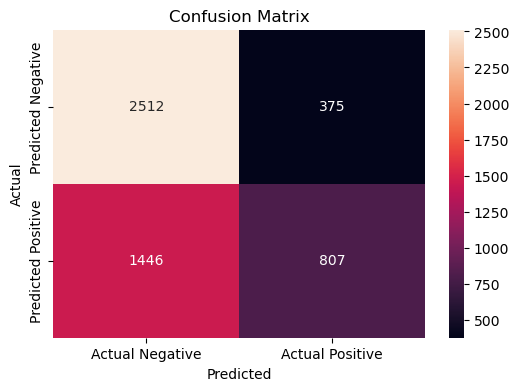

In [80]:
# Initialize and train the KNN model with all features
model = KNeighborsClassifier(n_neighbors=best_k) 
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model by calculating the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate log loss score
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1] 
log_loss_score = log_loss(y_test, y_pred_prob)
print(f"Log Loss: {log_loss_score}\n")

# Additional evaluation metrics
print("Classification Report:")
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
display(report_df)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert the confusion matrix to a DataFrame
cm_df = pd.DataFrame(cm,
                   index=["Predicted Negative", "Predicted Positive"],
                   columns=["Actual Negative", "Actual Positive"])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In a next step we have to evaluate which features we want to include. As the knn algorithm is a distance metric, the best number of neighbours and and best features influence each other. To get the best score we do univariate feature selection

In [81]:
accuracy_scores = {}

for n in range(1, 12):
    selector = SelectKBest(chi2, k=n)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    for k in range(1, 41):
        knn_classifier = KNeighborsClassifier(n_neighbors=k)
        knn_classifier.fit(X_train_selected, y_train)
        y_pred = knn_classifier.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores[(n, k)] = accuracy    

Accuracy: 0.6575875486381323
Classification Report:


,precision,recall,f1-score,support
0.0,0.648017,0.854520,0.737078,2887.000000
1.0,0.684921,0.405237,0.509202,2253.000000
accuracy,0.657588,0.657588,0.657588,0.657588
macro avg,0.666469,0.629879,0.623140,5140.000000
weighted avg,0.664193,0.657588,0.637194,5140.000000


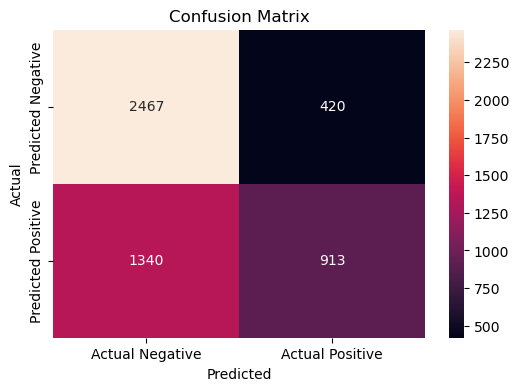

In [82]:
best_n, best_k = max(accuracy_scores, key=accuracy_scores.get)

selector = SelectKBest(chi2, k=best_n)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Initialize KNN classifier with best k retrieved from the previous step
knn_classifier = KNeighborsClassifier(n_neighbors=best_k)

# Train the model
knn_classifier.fit(X_train_selected, y_train)

# Make predictions
y_pred = knn_classifier.predict(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Additional evaluation metrics
print("Classification Report:")
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
display(report_df)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert the confusion matrix to a DataFrame
cm_df = pd.DataFrame(cm,
                   index=["Predicted Negative", "Predicted Positive"],
                   columns=["Actual Negative", "Actual Positive"])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [83]:
mask = selector.get_support()
selected_feature_names = X_train.columns[mask]
selected_feature_names

Index(['minutes_remaining', 'period', 'seconds_remaining', 'home',
       'encoded_action_type', 'encoded_season', 'encoded_shot_type',
       'encoded_opponent', 'encoded_new_shot_zone_area'],
      dtype='object')

We see that we get a slightly better accuracy score using only the following feeatures: `minutes_remaining`, `period`, `seconds_remaining`, `home`, `encoded_action_type`, `encoded_season`, `encoded_shot_type`,
`encoded_opponent`, and `encoded_new_shot_zone_area`.

Now we also try to do it by one hot encoding the categorical variables.

In [98]:
# Extract variable to predict
y = df.dropna(subset=["shot_made_flag"])["shot_made_flag"]

# Seperate the data in a DataFrame with the shots we have to predict for the Kaggle competition and one hot encode
# all the columns
df_predict = df_copy[df_copy["shot_made_flag"].isna()]
df_predict = df_predict.drop(columns=["shot_made_flag", "loc_x", "loc_y", "shot_id"])
df_predict = pd.get_dummies(df_predict, columns=["period"])
df_predict = pd.get_dummies(df_predict, columns=df.select_dtypes(include=["object"]).columns).astype(int)

# Seperate the data in a DataFrame with the know shots and one hot encode all the columns
df_encoded = df_copy.dropna(subset=["shot_made_flag"])
df_encoded = df_encoded.drop(columns=["shot_made_flag", "loc_x", "loc_y", "shot_id"])
df_encoded = pd.get_dummies(df_encoded, columns=["period"])
df_encoded = pd.get_dummies(df_encoded, columns=df.select_dtypes(include=["object"]).columns).astype(int)

df_encoded

,minutes_remaining,playoffs,seconds_remaining,overtime,home,period_1,period_2,period_3,period_4,period_5,period_6,period_7,action_type_Alley Oop Dunk Shot,action_type_Alley Oop Layup shot,action_type_Cutting Layup Shot,action_type_Driving Bank shot,action_type_Driving Dunk Shot,action_type_Driving Finger Roll Layup Shot,action_type_Driving Finger Roll Shot,action_type_Driving Floating Bank Jump Shot,action_type_Driving Floating Jump Shot,action_type_Driving Hook Shot,action_type_Driving Jump shot,action_type_Driving Layup Shot,action_type_Driving Reverse Layup Shot,action_type_Driving Slam Dunk Shot,action_type_Dunk Shot,action_type_Fadeaway Bank shot,action_type_Fadeaway Jump Shot,action_type_Finger Roll Layup Shot,action_type_Finger Roll Shot,action_type_Floating Jump shot,action_type_Follow Up Dunk Shot,action_type_Hook Bank Shot,action_type_Hook Shot,action_type_Jump Bank Shot,action_type_Jump Hook Shot,action_type_Jump Shot,action_type_Layup Shot,action_type_Pullup Bank shot,action_type_Pullup Jump shot,action_type_Putback Dunk Shot,action_type_Putback Layup Shot,action_type_Putback Slam Dunk Shot,action_type_Reverse Dunk Shot,action_type_Reverse Layup Shot,action_type_Reverse Slam Dunk Shot,action_type_Running Bank shot,action_type_Running Dunk Shot,action_type_Running Finger Roll Layup Shot,action_type_Running Finger Roll Shot,action_type_Running Hook Shot,action_type_Running Jump Shot,action_type_Running Layup Shot,action_type_Running Pull-Up Jump Shot,action_type_Running Reverse Layup Shot,action_type_Running Slam Dunk Shot,action_type_Running Tip Shot,action_type_Slam Dunk Shot,action_type_Step Back Jump shot,action_type_Tip Layup Shot,action_type_Tip Shot,action_type_Turnaround Bank shot,action_type_Turnaround Fadeaway shot,action_type_Turnaround Finger Roll Shot,action_type_Turnaround Hook Shot,action_type_Turnaround Jump Shot,season_1996-97,season_1997-98,season_1998-99,season_1999-00,season_2000-01,season_2001-02,season_2002-03,season_2003-04,season_2004-05,season_2005-06,season_2006-07,season_2007-08,season_2008-09,season_2009-10,season_2010-11,season_2011-12,season_2012-13,season_2013-14,season_2014-15,season_2015-16,shot_type_2PT Field Goal,shot_type_3PT Field Goal,opponent_ATL,opponent_BKN,opponent_BOS,opponent_CHA,opponent_CHI,opponent_CLE,opponent_DAL,opponent_DEN,opponent_DET,opponent_GSW,opponent_HOU,opponent_IND,opponent_LAC,opponent_MEM,opponent_MIA,opponent_MIL,opponent_MIN,opponent_NJN,opponent_NOH,opponent_NOP,opponent_NYK,opponent_OKC,opponent_ORL,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS,new_shot_zone_area_Above the Break 3,new_shot_zone_area_Around Rim,new_shot_zone_area_Backcourt,new_shot_zone_area_Left Corner 3,new_shot_zone_area_Left Long Baseline,new_shot_zone_area_Left Long Wing,new_shot_zone_area_Left Mid Baseline to Elbow,new_shot_zone_area_Long Straight,new_shot_zone_area_Mid Straight,new_shot_zone_area_Right Corner 3,new_shot_zone_area_Right Long Baseline,new_shot_zone_area_Right Long Wing,new_shot_zone_area_Right Mid Baseline to Elbow
1,10,0,22,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,7,0,45,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,6,0,52,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,6,0,19,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,

We start again with training a KNN model with all features.

In [99]:
# Select all features variables
X = df_encoded

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale all features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [100]:
accuracy_scores = []

for k in range(1, 41):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
best_k = k_values[accuracy_scores.index(max(accuracy_scores))]

Accuracy: 0.6558365758754864
Classification Report:


,precision,recall,f1-score,support
0.0,0.639401,0.888119,0.743512,2887.000000
1.0,0.714159,0.358189,0.477091,2253.000000
accuracy,0.655837,0.655837,0.655837,0.655837
macro avg,0.676780,0.623154,0.610302,5140.000000
weighted avg,0.672170,0.655837,0.626732,5140.000000


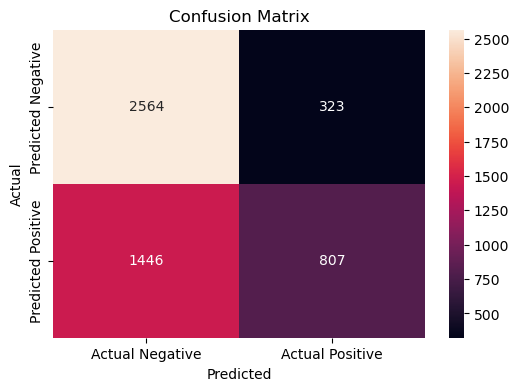

In [101]:
# Initialize and train the KNN model with all features
model = KNeighborsClassifier(n_neighbors=best_k) # You can adjust the number of neighbors
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model by calculating the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Additional evaluation metrics
print("Classification Report:")
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
display(report_df)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert the confusion matrix to a DataFrame
cm_df = pd.DataFrame(cm,
                   index=["Predicted Negative", "Predicted Positive"],
                   columns=["Actual Negative", "Actual Positive"])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

We can see that the result is better than the one for all the features without one hot encoding.

---

Now we are going to do univeriate feauture selection on on our hot encoded data. As this operation is computationally too expensive due to the largely expended column size, we stop after 20 iterations.

In [102]:
accuracy_scores = {}

for n in range(1, 21):
    selector = SelectKBest(chi2, k=n)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    for k in range(1, 41):
        knn_classifier = KNeighborsClassifier(n_neighbors=k)
        knn_classifier.fit(X_train_selected, y_train)
        y_pred = knn_classifier.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores[(n, k)] = accuracy

Accuracy: 0.6587548638132296
Classification Report:


,precision,recall,f1-score,support
0.0,0.676535,0.751992,0.712270,2887.000000
1.0,0.629208,0.539281,0.580784,2253.000000
accuracy,0.658755,0.658755,0.658755,0.658755
macro avg,0.652871,0.645636,0.646527,5140.000000
weighted avg,0.655790,0.658755,0.654636,5140.000000


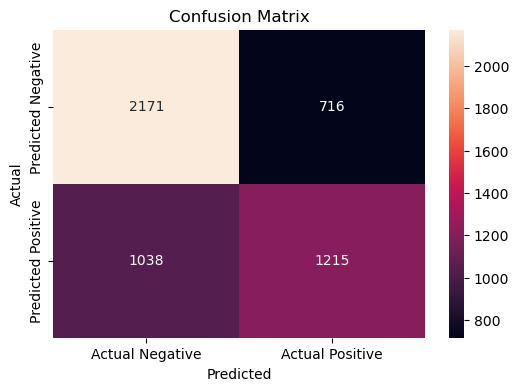

In [111]:
best_n, best_k = max(accuracy_scores, key=accuracy_scores.get)

selector = SelectKBest(chi2, k=best_n)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Initialize KNN classifier with best k retrieved from the previous step
knn_classifier = KNeighborsClassifier(n_neighbors=best_k)

# Train the model
knn_classifier.fit(X_train_selected, y_train)

# Make predictions
y_pred = knn_classifier.predict(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


# Additional evaluation metrics
print("Classification Report:")
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
display(report_df)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert the confusion matrix to a DataFrame
cm_df = pd.DataFrame(cm,
                   index=["Predicted Negative", "Predicted Positive"],
                   columns=["Actual Negative", "Actual Positive"])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [108]:
mask = selector.get_support()
selected_feature_names = X_train.columns[mask]
print(selected_feature_names)

Index(['action_type_Driving Layup Shot', 'action_type_Jump Shot',
       'action_type_Running Jump Shot', 'action_type_Slam Dunk Shot',
       'shot_type_3PT Field Goal', 'new_shot_zone_area_Around Rim'],
      dtype='object')


The result we get is better than the one using univariate feature selection without one hot encoding our data first. Further we also get a better accuracy score by only including the following features: `action_type_Driving Layup Shot`, `action_type_Jump Shot`, `action_type_Running Jump Shot`, `action_type_Slam Dunk Shot`, `shot_type_3PT Field Goal`, and `new_shot_zone_area_Around Rim`.

## 6. Conclusions and Future Work

In conclusion, the project *Kobe Bryant Shot Selection* successfully demonstrated the machine learning techniques we covered in the course and also feature engineering strategies. Initially, 13 attributes were dropped and three new ones were created as part of the preprocessing stage. This helped to simplify the dataset and focus on the most relevant features for the task at hand.

Two different models were used in the project: Logistic Regression with Recursive Feature Elimination (RFE) and Backward Elimination, and K-Nearest Neighbors (KNN) with Univariate Feature Selection. Both models showed promising results, but further improvement was sought.

Upon analyzing the accuracy and log-loss results, it was observed that the use of One Hot Encoding significantly enhanced the performance of both models. This technique transformed categorical variables into a binary vector representation, thereby improving the interpretability and performance of the models. 

The best result were obtained by the logistic regression model using RFE for feature selection and one hot encoding for feature engineering. This model was able to predict outcomes with accuracy of 68%.

Overall, the project highlighted the importance of effective preprocessing, feature engineering, and feature selection techniques in machine learning. It also underscored the impact of using appropriate encoding methods on model performance. The insights gained from this project can be applied to similar problems in the field of sports analytics or any other domain where predictive modeling is required.

For future work we would consider experimenting with more complex machine learning models like the one we saw from Kaggle users, such as Random Forest or XGBoost.

## 7. References

1. https://www.kaggle.com/competitions/kobe-bryant-shot-selection/code
2. https://towardsdatascience.com/nba-data-science-93e0314bb45e
3. https://github.com/mageirakos/kobe-bryant-shot-selection/blob/master/main.ipynb